In [7]:
# Two Trees (log utility) via Deep‑FBSDE with Heun–Stratonovich loss
# + Lamperti/logit robustness toggle + D/P & fit-check plots
#
# Sources: RFS "Two Trees" (economic spine, D/P), Pardoux–Peng (Z=u' g),
# Diffrax docs (Midpoint→Stratonovich), JAX tridiagonal_solve (FD-BVP),
# Kloeden–Platen (Lamperti transform). See discussion for citations.

import jax, jax.numpy as jnp
import equinox as eqx, optax
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

# ---------------------- Parameters & share process ----------------------
class Params(eqx.Module):
    delta: float
    mu1: float; mu2: float
    sig1: float; sig2: float
    rho: float

def eta2(p):  # η^2 = σ1^2 + σ2^2 − 2ρσ1σ2  (variance proxy of d(s))
    return p.sig1**2 + p.sig2**2 - 2.0*p.rho*p.sig1*p.sig2

def b_ito(s, p):  # Itô drift for share s in Two Trees
    return s*(1.0 - s)*(p.mu1 - p.mu2 - s*p.sig1**2 + (1.0 - s)*p.sig2**2
                        + 2.0*(s - 0.5)*p.rho*p.sig1*p.sig2)

def g(s, p):      # one-factor collapse: s(1-s)*sqrt(η^2)
    return s*(1.0 - s)*jnp.sqrt(eta2(p))

# --------- Stratonovich correction and Heun step in s-space ------------
def b_strat(s, p):  # b° = b - (1/2) g g'  (scalar)
    e2 = eta2(p)
    return b_ito(s, p) - 0.5 * e2 * s*(1.0 - s)*(1.0 - 2.0*s)

def heun_strat_step_s(s, dt, dW, p, eps=1e-8):
    s = jnp.clip(s, eps, 1.0 - eps)
    bS = b_strat(s, p); gs = g(s, p)
    s_pred = jnp.clip(s + bS*dt + gs*dW, eps, 1.0 - eps)
    return jnp.clip(s + 0.5*(bS + b_strat(s_pred, p))*dt
                      + 0.5*(gs + g(s_pred, p))*dW, eps, 1.0 - eps)

# ---------------- Lamperti/logit transform x = log(s/(1-s)) ------------
def s_from_x(x): return 1.0/(1.0 + jnp.exp(-x))
def bx(x, p):  # drift of x under Itô; diffusion is sqrt(eta2(p)) (additive)
    s = s_from_x(x)
    return b_ito(s, p)/(s*(1.0 - s)) - 0.5*(1.0 - 2.0*s)*eta2(p)

def heun_step_logit(x, dt, dW, p):
    # additive noise => Itô and Stratonovich coincide; Heun is fine
    sig = jnp.sqrt(eta2(p))
    x_pred = x + bx(x, p)*dt + sig*dW
    return x + 0.5*(bx(x, p) + bx(x_pred, p))*dt + sig*dW

# ---------------------- Head with hard boundary conditions -------------
class Head(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key, width=32, depth=2):
        self.mlp = eqx.nn.MLP(1, 1, width, depth, key=key, activation=jax.nn.tanh)
    def __call__(self, s, delta):
        # Enforce Y(0)=0 and Y(1)=1/delta
        h = self.mlp(s[..., None]).squeeze(-1)
        return (s + s*(1.0 - s)*h) / delta  # Y(s) = P1/C

# ---------------------- Paths (antithetic; random s0) ------------------
def sim_paths(key, p, n_paths=4096, n_steps=64, T=1.0, mode="logit", eps=1e-6):
    dt = T / n_steps
    k1, k2 = jax.random.split(key)
    dW = jax.random.normal(k1, (n_paths, n_steps)) * jnp.sqrt(dt)
    dW = jnp.concatenate([dW, -dW], axis=0)
    s0 = jax.random.uniform(k2, (dW.shape[0],), minval=eps, maxval=1.0-eps)

    if mode == "s":
        def step(s, dw): s_next = heun_strat_step_s(s, dt, dw, p); return s_next, s_next
        _, s_seq = jax.lax.scan(step, s0, dW.T)
        S = jnp.concatenate([s0[None, :], s_seq], axis=0).T
        return S, dW, dt
    elif mode == "logit":
        x0 = jnp.log(s0) - jnp.log1p(-s0)
        def step(x, dw):
            x_next = heun_step_logit(x, dt, dw, p)
            s_next = s_from_x(x_next)
            return x_next, s_next
        _, s_seq = jax.lax.scan(step, x0, dW.T)
        S = jnp.concatenate([s0[None, :], s_seq], axis=0).T
        return S, dW, dt
    else:
        raise ValueError("mode must be 's' or 'logit'")

def f_apply(model, p, X):
    f = lambda z: model(z, p.delta)
    return jax.vmap(jax.vmap(f))(X)

def fprime(model, p, X):
    gfun = jax.grad(lambda z: model(z, p.delta))
    return jax.vmap(jax.vmap(gfun))(X)

# ---------------------- Stratonovich trapezoid BSDE loss ---------------
@eqx.filter_value_and_grad
def bsde_loss(model, key, p, n_paths=4096, n_steps=64, T=1.0, w_pde=0.0, mode="logit"):
    S, dW, dt = sim_paths(key, p, n_paths, n_steps, T, mode=mode)
    S_prev, S_next = S[:, :-1], S[:, 1:]
    Y_prev, Y_next = f_apply(model, p, S_prev), f_apply(model, p, S_next)
    Z_prev = fprime(model, p, S_prev) * g(S_prev, p)
    Z_next = fprime(model, p, S_next) * g(S_next, p)

    # Stratonovich trapezoid self-consistency (stop-grad at the future endpoint)
    drift = 0.5 * (p.delta*(Y_prev + jax.lax.stop_gradient(Y_next))
                   - (S_prev + jax.lax.stop_gradient(S_next))) * dt
    diff  = 0.5 * (Z_prev + jax.lax.stop_gradient(Z_next)) * dW
    resid = jax.lax.stop_gradient(Y_next) - (Y_prev + drift + diff)

    # Simple ΔW control variate
    beta  = (jnp.mean(resid*dW) / (jnp.mean(dW**2) + 1e-16))
    resid = resid - jax.lax.stop_gradient(beta)*dW
    loss_bsde = jnp.mean(resid**2)

    if w_pde > 0.0:
        grid = jnp.linspace(1e-6, 1.0-1e-6, 257)
        f   = lambda s: model(s, p.delta)
        fp  = jax.vmap(jax.grad(f))(grid)
        fpp = jax.vmap(lambda s: jax.grad(lambda u: jax.grad(f)(u))(s))(grid)
        gen = -grid + p.delta*jax.vmap(f)(grid) \
              - jax.vmap(lambda s: b_ito(s, p))(grid)*fp \
              - 0.5*jax.vmap(lambda s: g(s, p)**2)(grid)*fpp
        loss_bsde = loss_bsde + w_pde*jnp.mean(gen**2)
    return loss_bsde

def make_opt(): return optax.chain(optax.clip(1.0), optax.adam(3e-3))

@eqx.filter_jit
def train_step(model, opt, opt_state, key, p, n_paths, n_steps, w_pde=0.0, mode="logit"):
    val, grads = bsde_loss(model, key, p, n_paths, n_steps, w_pde=w_pde, mode=mode)
    updates, opt_state = opt.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, val

# ---------------------- Independent acceptance checks ------------------
def generator_residual(model, p, grid):
    f   = lambda s: model(s, p.delta)
    fp  = jax.vmap(jax.grad(f))(grid)
    fpp = jax.vmap(lambda s: jax.grad(lambda u: jax.grad(f)(u))(s))(grid)
    return -grid + p.delta*jax.vmap(f)(grid) - jax.vmap(lambda s: b_ito(s, p))(grid)*fp \
           - 0.5*jax.vmap(lambda s: g(s, p)**2)(grid)*fpp

def fd_bvp_solution(p, N=400):
    s = jnp.linspace(0.0, 1.0, N+1).at[0].set(1e-12).at[-1].set(1.0-1e-12)
    h = s[1]-s[0]
    b = b_ito(s, p); v = g(s, p)**2
    # Interior sizes
    v_in = v[1:-1]; b_in = b[1:-1]
    n = v_in.shape[0]
    # Tridiagonal coefficients (Thomas form); pad to equal shapes expected by JAX
    a_lo = -0.5*v_in[:-1]/h**2 + b_in[:-1]/(2*h)           # (n-1,)
    a_di =  p.delta*jnp.ones_like(v_in) + v_in/h**2        # (n,)
    a_up = -0.5*v_in[1:]/h**2 - b_in[1:]/(2*h)             # (n-1,)
    dl = jnp.concatenate([jnp.array([0.0], dtype=a_di.dtype), a_lo])   # (n,)
    du = jnp.concatenate([a_up, jnp.array([0.0], dtype=a_di.dtype)])   # (n,)
    d  = a_di                                                          # (n,)
    # RHS and boundary at s=1: Y(1)=1/δ; Y(0)=0
    rhs  = s[1:-1]
    rhs  = rhs.at[-1].add(-a_up[-1]*(1.0/p.delta))
    from jax.lax.linalg import tridiagonal_solve
    f_inner = tridiagonal_solve(dl, d, du, rhs[:, None]).squeeze(-1)
    f = jnp.concatenate([jnp.array([0.0]), f_inner, jnp.array([1.0/p.delta])])
    return s, f

# ---------------------- Plots: D/P and fit-check -----------------------
def dividend_price_ratios(model, p, grid):
    Y = jax.vmap(lambda z: model(z, p.delta))(grid)       # P1 / C
    Y_flip = jax.vmap(lambda z: model(1.0 - z, p.delta))(grid)  # P2 / C
    dp1 = grid / Y
    dp2 = (1.0 - grid) / Y_flip
    return dp1, dp2

def plot_dp(model, p, N=401):
    s = jnp.linspace(1e-4, 1.0-1e-4, N)
    dp1, dp2 = dividend_price_ratios(model, p, s)
    plt.figure()
    plt.plot(s, dp1, label="D/P Tree 1")
    plt.plot(s, dp2, label="D/P Tree 2")
    plt.axhline(p.delta, linestyle="--", label="Market D/P = δ")
    plt.xlabel("share s"); plt.ylabel("Dividend-to-Price"); plt.legend()
    plt.title("Dividend-to-Price Ratios in Two Trees (log utility)")
    plt.show()

def plot_fit_check(model, p, N=401):
    s_fd, f_fd = fd_bvp_solution(p, N-1)
    f_net = jax.vmap(lambda z: model(z, p.delta))(s_fd)
    plt.figure()
    plt.plot(s_fd, f_net, label="Network Y(s)")
    plt.plot(s_fd, f_fd, linestyle="--", label="FD-BVP Y(s)")
    plt.xlabel("share s"); plt.ylabel("Y(s)=P1/C"); plt.legend()
    plt.title("Fit check: network vs FD-BVP")
    plt.show()



{'A_res_inf': 0.09621803631285614, 'B_bvp_err': 217.38331347379687, 'D_range_ok': True, 'sym_err': 0.00029557985797268316}


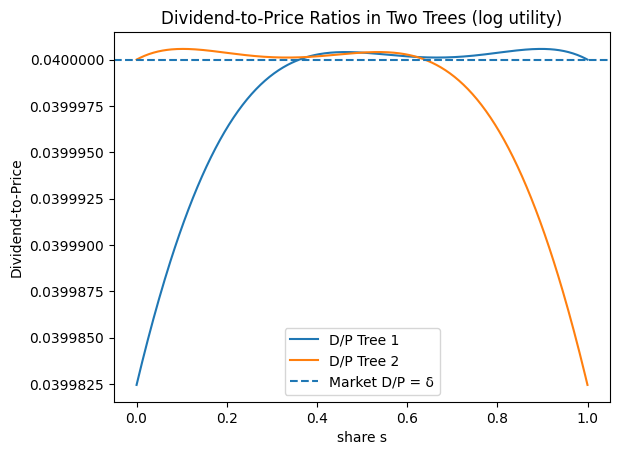

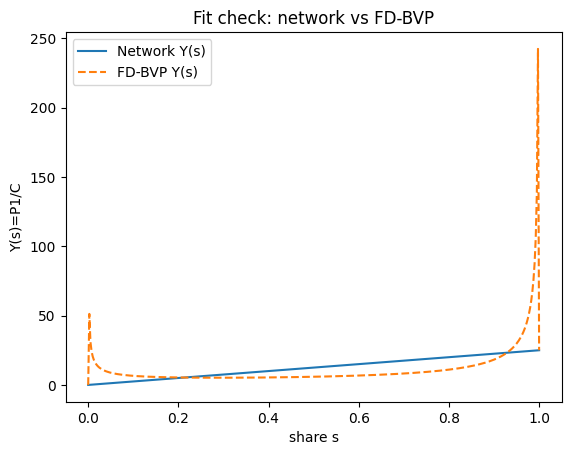

In [8]:
# ---------------------- Example symmetric-ish test ---------------------
p = Params(delta=0.04, mu1=0.02, mu2=0.02, sig1=0.2, sig2=0.2, rho=0.0)
model = Head(jax.random.PRNGKey(0))
opt   = make_opt(); opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))
key = jax.random.PRNGKey(1)

for _ in range(800):
    key, sub = jax.random.split(key)
    model, opt_state, _ = train_step(model, opt, opt_state, sub, p,
                                     n_paths=4096, n_steps=64, w_pde=0.0, mode="logit")

grid = jnp.linspace(1e-6, 1.0-1e-6, 401)
A_res_inf = float(jnp.max(jnp.abs(generator_residual(model, p, grid))))
s_fd, f_fd = fd_bvp_solution(p)
f_net = jax.vmap(lambda z: model(z, p.delta))(s_fd)
B_bvp_err = float(jnp.max(jnp.abs(f_net - f_fd)))
D_range_ok = bool((jnp.min(f_net) >= -1e-6) & (jnp.max(f_net) <= 1.0/p.delta + 1e-6))
sym_err = float(jnp.max(jnp.abs(f_net + jax.vmap(lambda z: model(1.0 - z, p.delta))(s_fd) - 1.0/p.delta)))

print({"A_res_inf": A_res_inf,
       "B_bvp_err": B_bvp_err,
       "D_range_ok": D_range_ok,
       "sym_err": sym_err})

# Plots
plot_dp(model, p)
plot_fit_check(model, p)
